# QuaSaR: Identifying EEW Rings - MMI Classifier

[Quake Safe Rings](./1a_stations_faultlnes_plot.ipynb) - In the efforts to understand the GeoNet datasets for havesting data that can be used in trialing the picking agorithms, we begin with the [GeoNet Strong Motion Database](https://www.geonet.org.nz/data/supplementary/nzsmdb), [rupture  model data](), and [processed recordings]() that are readily available<sup>[1](#myftnote1)</sup>. The idea is to classify the historic data by the various measures made available throught the datasets. Some of the measures include the moment magnitude, hycenter location, measuring station locations, tectonic type, rupture length, total duration, and so on.

<a name="ftnote1">[1]</a>: [All GeoNet data and images](https://github.com/GeoNet/data), with updates on Github, are made available free of charge through the GeoNet project to facilitate research into hazards and assessment of risk. GeoNet is sponsored by the New Zealand Government through its agencies: Earthquake Commission (EQC), GNS Science and Land Information New Zealand (LINZ), the National Emergency Management Agency (NEMA) and the Ministry of Business, Innovation and Employment (MBIE).

In [2]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

import logging
from functools import lru_cache

## Hueristically mining the strong motion database

[Flatfile specifications](https://static.geonet.org.nz/info/resources/applications_data/earthquake/strong_motion/Flatfiles_ColumnExplanation.pdf). They contain the horizontal and vertical acceleration response spectra, and horizontal and vertical Fourier amplitude spectra of acceleration.

We begin with mining the data with attention on [feature extraction](https://machinelearningmastery.com/feature-extraction-on-tabular-data/)
1. _Mw_: Moment Magnitude
1. _Orign_time_: Earthquake originating time
1. _TectClass_: Tectonic Class of crustal, slab, or interface
1. _Mech_: Focal mechanism whether it is a slip, strike, etc
1. _Length_km_: rupture length in Kilometers
1. _Width_km_: rupture width in Kilometers
1. _TotalDuration_: Total duration of the earthquake

### Class to load and clean data

In [6]:
#import torch
import pandas as pd
import datetime as dt
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

'''
    CSV LOAD into DataFrame and remove unnecessary columns
'''
strong_motion_df = pd.read_csv('../data/flatfiles/NZdatabase_flatfile_Significant_Duration_horizontal.csv', encoding = "UTF-8")

strong_motion_df = strong_motion_df.drop(columns=['CuspID','References','Location','Record'], axis=1)
strong_motion_df = strong_motion_df.replace('>2',float(2.1))
strong_motion_df = strong_motion_df.replace('<0.1',float(0.1))
''' Convert datetime to a defined as YYYYMMDD time rounded to 0 or 1 day '''
for t_idx, t_val in enumerate(strong_motion_df['Origin_time']):
    t_dt = dt.datetime.fromisoformat(t_val[0:19])
    t_float = float(t_dt.year*100000+t_dt.month*1000+t_dt.day*10+(round(t_dt.hour/24)))
    strong_motion_df['Origin_time'][t_idx]=t_float

_lst_cate_data_cols = [
                        'Origin_time',     # Origin time of earthquake in UTC
                        'TectClass',       # Tectonic classification, either ‘crustal’, ‘interface’, or ‘slab’
                        'Mech',            #
                        'HWFW',            #
                        'SiteCode',        #
                        'SiteClass1170',   #
                        'Vs30Uncert',      #
                        'TsiteUncert',     #
                        'Z1Uncertainty'    #
                      ]
cat_strong_motion_df = strong_motion_df[_lst_cate_data_cols]
num_strong_motion_df = strong_motion_df.drop(_lst_cate_data_cols, axis=1)
print(f"Shape of the Categorical DataFrame: {cat_strong_motion_df.shape}")
print(f"Shape of the Numerical DataFrame: {num_strong_motion_df.shape}")

''' LabelEncoder to convert the categorical data to numerical float64 '''
le = LabelEncoder()
for __cat_col_name in _lst_cate_data_cols:
    strong_motion_df[__cat_col_name] = le.fit_transform(strong_motion_df[__cat_col_name]).astype(float) 
print(f"Shape of the full DataFrame: {strong_motion_df.shape}")
print(f'\nPost label encoding of categorical data \n{strong_motion_df.head(3)}')

AttributeError: module 'datetime' has no attribute 'fromisoformat'

### Method to pariwise plot measures

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
'''
    Pairwise density plots for all the column variables
    attribute specs: https://static.geonet.org.nz/info/resources/applications_data/earthquake/strong_motion/Flatfiles_ColumnExplanation.pdf
'''
plot_df = strong_motion_df[[
                            'Mw',          # Moment Magnitude
                            'MwUncert',    # Mw uncertainty class 
                            'Origin_time', # Origin time of earthquake in UTC
                            'TectClass',   # Tectonic classification, either ‘crustal’, ‘interface’, or ‘slab’
                            'Mech',        # Focal mechanism: S→strike-slip, N→normal,R→reverse,U→unknown
                            'PreferredFaultPlane', # 1→one fault plane orientation is preferred, 1→Unknown
                            'Strike',      # Strike angle (degrees)
                            'Dip',         # Dip angle (degrees)
                            'Rake',        # Rake angle (degrees)
                            'HypLat',      # Hypercenter Latitude
                            'HypLon',      # Hypercernter Longitude
                            'StationLat',  # Recording Station Latitude
                            'StationLon',  # Recording Station Longitude
                            'HypN',        # Northing of Hyppercenter
                            'HypE',        # Easting of Hypercernter
                            'StationN',    # Northing of Station
                            'StationE',    # Easting of Station
                            'LENGTH_km',   # Infered rupture Length in Kilometers
                            'WIDTH_km',    # Infered down-dip rupture Width in Kilometers
                            'TotalDuration'# Total Duration of the earthquake
                           ]]
lst_plot_cols = ['Origin_time','Mw','TectClass','Mech','LENGTH_km','TotalDuration']
print(f"Description of each plotted measure: \n{pd.DataFrame(plot_df[lst_plot_cols].describe(include='all')).T}")
g = sns.pairplot(plot_df[lst_plot_cols], 
             hue='Mw', corner=True,hue_order=None,
             kind='scatter', diag_kind='auto', height=7,markers='d')
g.fig.suptitle("Pair Plots for relevant measures") # y= some height>1


## Applying an NN Classifier
The intent is to use data available from GeoNet strong motion and felt databases to encapsulate a a Modified Mercalli Intensity (MMI) score. We use an Artifical Nueral Network (NN) to classify the data from the several flat files. The reason to use an NN is because of the large volume of covariates in the dataset. Subsequently assess wether a the classifier contribute to the basis of proposing an MMI for a new scenario of the given covariates.

Of particular intetrest to this notebook is investigating the use of pytorch and tensor products and their capabilties to build a model for evaluating Objective II.C --  Picking earthquakes. For such we need to achieve the following steps
1. Encode or vectorize the data; especially with transforming categorical labels to numerical data; ideally as embeddings (currently only using the LabelEncoder instead of the HotEncoder)
1. [Split the data](https://palikar.github.io/posts/pytorch_datasplit/) to generate train, validation, and test datasets to,
   1. train it with 300 epochs to reach an acceptable long tail and near-zero softmax defined in the NN model
   1. validate 

### Method to split dataset into train, validation, & test

In [7]:
''' METHOD DATALOADER - build the training dataloader object'''
# Load necessary Pytorch packages
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import numpy as np

shuffle = True
test_train_split = 0.8
val_train_split = 0.2

''' Data smithing '''
try:
    dataset = strong_motion_df.drop(['Origin_time','SiteCode'], axis=1).astype(float)

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    test_split = int(np.floor(test_train_split * dataset_size))

    ''' shuffle if True '''
    if shuffle:
        np.random.shuffle(indices)

except Exception as err:
    print("Error message:", err)

''' Split the indices into train, valid, and test '''
try:
    train_indices, test_indices = indices[:test_split], indices[test_split:]
    train_size = len(train_indices)
    validation_split = int(np.floor((1 - val_train_split) * train_size))
    train_indices, val_indices = train_indices[ : validation_split], train_indices[validation_split:]

    #_targets = dataset[['TectClass','Mech']]
    #_inputs = dataset.drop(['TectClass','Mech'], axis=1)
    _targets = dataset['Mech']
    _inputs = dataset.drop(['Mech'], axis=1)
    print('Classes',set(_targets))
except Exception as err:
    print("Error message:", err)

''' Train dataset from split indeces '''
try:
    train_inputs = np.array(_inputs.iloc[train_indices], dtype=np.float32)
    train_targets= np.array(_targets.iloc[train_indices], dtype=np.float32)

    train_data = []
    for i in range(len(train_inputs)):
        train_data.append([train_inputs[i], train_targets[i]])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, num_workers=0, shuffle=False)
    print("Train data loader length", str(len(train_loader)))
except Exception as err:
    print("Error message:", err)

''' Validation dataset from split indeces '''
try:
    val_inputs = np.array(_inputs.iloc[val_indices], dtype=np.float32)
    val_targets= np.array(_targets.iloc[val_indices], dtype=np.float32)

    val_data = []
    for i in range(len(val_inputs)):
        val_data.append([val_inputs[i], val_targets[i]])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, num_workers=0, shuffle=False)
    print("Validation data loader length", str(len(val_loader)))
except Exception as err:
    print("Error message:", err)


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Classes {0.0, 1.0, 2.0, 3.0, 4.0}
Train data loader length 275
Validation data loader length 69


## The NN Model
* [Description of the NN Layers and tuning the Hyperparameters](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a)
* [d2l Pytorch tutorial](https://github.com/dsgiitr/d2l-pytorch)
* [NN architecture](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464) for building the NN model.

__Parameters__
* _in_features_:
* _out_features_:
* _layers_: List which contains number of neurons for all the layers
* _p_: 

#### Input layer
Comprises both numerical and categorical data. We have generated embeddings for all the categorical data.
* ```n_features: int=46``` (of 55)

#### Hidden MLP
1. [Batch Normalization](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd) - to avoid the learning algorithm spend much time oscillating in the plateau, we normalize the input features such that all the features would be on the same scale.
1. [Linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) takes ```n_features: int=46``` (of 55) and ```n_out_feature: int=2``` (of 5).
1. [RELU]()
1. [Dropout]()
1. [Autoencoder](https://analyticsindiamag.com/hands-on-guide-to-implement-deep-autoencoder-in-pytorch-for-image-reconstruction/) designed for classification, clustering, and feature compression

__TODO__ convert the feature vector to a feature matrix to make use of:
1. [Pooling](https://deepai.org/machine-learning-glossary-and-terms/max-pooling) - “accumulate” features from maps generated by convolving a filter over the feature matrix. Formally, its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network; in part to help over-fitting by providing an abstracted form of the representation
1. [Convolusion](https://www.nature.com/articles/s41598-019-47765-6) - convolution neural network (CNN) architecture from deep neural networks accepts a sample as an image (i.e. a matrix of size m × n) and performs feature extraction and classification via hidden layers (such as convolutional layers, RELU layer, max-pooling layers). First step is [reshaping the tensor view](https://discuss.pytorch.org/t/convert-1d-tensor-to-2d-tensor/5599/2) that is acceptable by [Conv2D NN class](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). 


#### Output Layer
The output classifiers are ```output={'Mw','TectClass','Mech','Length_km','Width_km', 'TotalDuration'}```. Therefore, we have ```n_out_features: int=1```. The set of outputs with their own classes should be able to define the [Modified Mercalli Intensity scale](https://www.usgs.gov/media/images/modified-mercalli-intensity-mmi-scale-assigns-intensities)

#### Weights
The weights are randomly generated for the ```2401 x 49``` tensors. 



In [8]:
'''
    CLASS Net MLP
'''
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    ''' Initialize the NN '''
    def __init__(self, n_in_features: int, n_out_features: int, layers: list, p=0.4):
        super().__init__()
        
        all_layers = []
        
        for i in layers:
            ''' feature extraction with convolusion and pooling '''
            all_layers.append(nn.Linear(n_in_features, n_out_features))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.Dropout(p))

        ''' TODO fix the matrix mismatch '''
#        all_layers.append(nn.Linear(layers[-1], n_out_features))

        self.layers = nn.Sequential(*all_layers)

    ''' Forward run of data through the NN model'''
    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, 1)
        # Apply softmax to x
#        output = F.log_softmax(x, dim=1)
        output = F.softmax(x,dim=1)
        return output
    
    ''' GET a NN model with prescribed in-out features and layer architecture '''
    def get_nn_model(train_loader):
        
        # Define Layers
        __layer = [52]

        train_loader_input, train_loader_target = next(iter(train_loader))
        print(f'Input train tensor data type: {train_loader_input.dtype} and {train_loader_input.size()}')
        print(f'Target train tensor data type: {train_loader_target.dtype} and {train_loader_target.size()}')
        ''' Define in and out features '''
        n_in_features = train_loader_input.shape[1]
        n_out_features = len(set(_targets))
        print(f'Building model with {n_in_features} in features, {n_out_features} out features, and hidden layer architecture {__layer} as hyperparameters')
        print(f"for the Train loader with shape {train_loader_input.shape} and target loader shape {train_loader_target.shape}")
        model = Net(n_in_features,n_out_features,layers=__layer,p=0.4) # On CPU
        return model, __layer

    ''' GET training performance (loss and accuracy) measures '''
    def get_train_perform(train_loader):
        train_accu = []
        train_loss = []
        train_correct = 0
        train_total = 0
        for train_idx, (train_data, train_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model.forward(train_data)
            _, train_predicted = torch.max(y_pred.data, 1)
            train_labels = train_labels.type(torch.LongTensor)
            train_single_loss = loss_function(y_pred, train_labels)
    
            train_single_loss.backward()
            optimizer.step()

            train_total += train_labels.size(0)
            train_correct += (train_predicted == train_labels).sum().item()

        train_accu.append(100 * train_correct / train_total)
        train_loss.append(train_single_loss)

        return train_accu, train_loss

    ''' GET validation performance (accuracy) measure '''
    def get_valid_perform(val_loader):
        val_accu = []
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_idx, (val_data, val_labels) in enumerate(val_loader):
                val_labels = val_labels.type(torch.LongTensor)
                y_pred = model.forward(val_data)
                _, val_predicted = torch.max(y_pred.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_accu.append(100 * val_correct / val_total)

        return val_accu


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Define and build the 'model'

In [9]:
import torch.optim as optim

''' Define learning rate '''
lr = 0.001
''' Define loss funcion '''
loss_function = nn.CrossEntropyLoss()

model, _layer = Net.get_nn_model(train_loader)
print(f"\n{model}")

''' Define optimizer
    TODO examine SDG and other optimizer protocols
'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(f'Optimizer with learning rate lr={lr} and \nParameters')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f' {name} {param.data.shape}')

Input train tensor data type: torch.float32 and torch.Size([10, 52])
Target train tensor data type: torch.float32 and torch.Size([10])
Building model with 52 in features, 5 out features, and hidden layer architecture [52] as hyperparameters
for the Train loader with shape torch.Size([10, 52]) and target loader shape torch.Size([10])

Net(
  (layers): Sequential(
    (0): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=52, out_features=5, bias=True)
    (3): Dropout(p=0.4, inplace=False)
  )
)
Optimizer with learning rate lr=0.001 and 
Parameters
 layers.0.weight torch.Size([52])
 layers.0.bias torch.Size([52])
 layers.2.weight torch.Size([5, 52])
 layers.2.bias torch.Size([5])


### Method to Train and Validate the NN model
good article on [training and validation](https://stackoverflow.com/questions/2976452/whats-is-the-difference-between-train-validation-and-test-set-in-neural-netwo)

In [10]:
val_loader_input, val_loader_target = next(iter(val_loader))
print(f"Validation loader shape {val_loader_input.shape} and target loader shape {val_loader_target.shape}")

Validation loader shape torch.Size([10, 52]) and target loader shape torch.Size([10])


In [11]:
''' Define the number of epochs to train the NN '''
epochs = 300
''' Define lists for loss and accuracy measures for each epoch'''
train_aggr_loss = []
train_aggr_accu = []
val_aggr_accu = []
 
''' Train the NN over epochs '''
print(f"Begin training for {epochs} epochs ...\n")
for i in range(epochs):
    i += 1
    _epoch_train_loss = []
    _epoch_train_accu = []
    _epoch_train_accu, _epoch_train_loss = Net.get_train_perform(train_loader)
    train_aggr_loss.append(_epoch_train_loss[0])
    train_aggr_accu.append(_epoch_train_accu[0])

    _epoch_val_accu = []
    _epoch_val_accu = Net.get_valid_perform(val_loader)
    val_aggr_accu.append(_epoch_val_accu[0])

    if i%25 == 1:
        print(f'epoch: {i:3} training loss: {_epoch_train_loss[0]:6.2f}')
        print(f'epoch: {i:3} training accuracy: {_epoch_train_accu[0]:6.2f}%')
        print(f'epoch: {i:3} validation accuracy: {_epoch_val_accu[0]:6.2f}%')

print(f'epoch: {i:3} loss: {_epoch_train_loss[0]:6.2f}')
print(f'epoch: {i:3} training accuracy: {_epoch_train_accu[0]:6.2f}%')
print(f'epoch: {i:3} validation accuracy: {_epoch_val_accu[0]:6.2f}%')


Begin training for 300 epochs ...

epoch:   1 training loss:   1.71
epoch:   1 training accuracy:  33.95%
epoch:   1 validation accuracy:  37.99%
epoch:  26 training loss:   1.39
epoch:  26 training accuracy:  59.56%
epoch:  26 validation accuracy:  57.50%
epoch:  51 training loss:   1.63
epoch:  51 training accuracy:  61.06%
epoch:  51 validation accuracy:  56.91%
epoch:  76 training loss:   1.50
epoch:  76 training accuracy:  61.57%
epoch:  76 validation accuracy:  58.08%
epoch: 101 training loss:   1.42
epoch: 101 training accuracy:  63.57%
epoch: 101 validation accuracy:  60.99%
epoch: 126 training loss:   1.34
epoch: 126 training accuracy:  61.53%
epoch: 126 validation accuracy:  58.95%
epoch: 151 training loss:   1.29
epoch: 151 training accuracy:  62.33%
epoch: 151 validation accuracy:  60.26%
epoch: 176 training loss:   1.37
epoch: 176 training accuracy:  63.02%
epoch: 176 validation accuracy:  62.45%
epoch: 201 training loss:   1.29
epoch: 201 training accuracy:  63.24%
epoch:

## Plot training process losses and accuracies

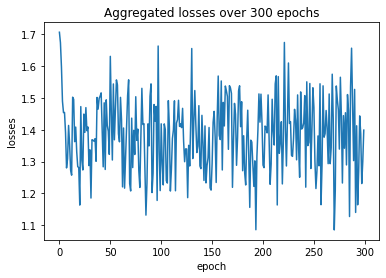

In [12]:
''' PLOT aggregated losses over the epoch '''
plt.plot(range(epochs), train_aggr_loss)
plt.ylabel('losses')
plt.xlabel('epoch');
plt.title(f'Aggregated losses over {epochs} epochs')
plt.show()

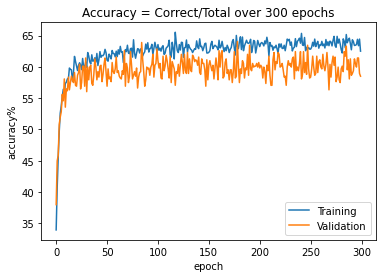

In [13]:
''' PLOT aggregated accuracies over the epochs  '''
plt.title(f'Accuracy = Correct/Total over {epochs} epochs')
plt.ylabel('accuracy%')
plt.xlabel('epoch');
plt.plot(range(epochs), train_aggr_accu, label='Training')
plt.plot(range(epochs), val_aggr_accu, label='Validation')
plt.legend(loc='lower right')
plt.show()

### OneHotEncoding [DEPRECATE?]

In [ ]:
'''
    DEPRECATE if the LabelEncoding is sufficient; else,
    TODO: OneHotEncode before building the the tensors
'''

import logging
from functools import lru_cache

logging.debug('Preprocessing data with OneHotEncoder')

'''
    OneHotEncoder to create the arrays for training, validation, and testing
'''
train_1hotenc = np.empty_like(train_ts)
for t_indx, t in enumerate(train_ts):
    print(t_indx,t.numpy())
    train_1hotenc[t_indx] = OneHotEncoder(categories='auto', drop=None, sparse=True, dtype='float64', 
                                  handle_unknown='error').fit_transform(t.numpy())
    print(train_1hotenc[t_indx])
train_1hotenc_ts = train_1hotenc
print(f"Shape of the OneHotencoded array: {train_1hotenc.shape}")
print(f"Datatype of the OneHotencoded array: {train_1hotenc.dtype}")